<img src='pics/otus.png'>

In [1]:
type("dgd")

str

In [2]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas_profiling
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# Подбор признаков

# Данные

https://www.kaggle.com/c/titanic

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.



## Data Dictionary

Variable	Definition	Key  
survival	Survival	0 = No, 1 = Yes  
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex	Sex	  
Age	Age in years	  
sibsp	# of siblings / spouses aboard the Titanic	  
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  
Variable Notes  

pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5  

sibsp: The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...   
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.  

**train.csv** - training set - тренировочный набор данных. В них известен ответ - survival - бинарный признак 0 (не выжил)/1 (выжил)  
**test.csv** - test set - тестовый набор данных. Ответ не известен. На них проверяется качество построенной модели.  
**gender_submission.csv** - пример формата данных, которые нужно отправить на kaggle.

## Алгоритм работы:  

* изучаем и преобразуем данные из train.csv
* строим модель и подбираем параметры, выбираем лучшую модель на преобразованных данных из train.csv
* фиксируем метод преобразований и модель
* применяем те же самые преобразования на test.csv  
* применяем модель на test.csv
* результат применения сохраняем файл в таком же формате как и в gender_submission.csv
* отправляем на kaggle
* повторяем все пункты (помним, что нельзя подбирать параметры модели делая submit - высокий риск переобучиться)


In [3]:
!head gender_submission.csv

In [4]:
!head train.csv

In [5]:
!head test.csv

In [6]:
df_train = pd.read_csv('train.csv', na_values='NaN')
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.46,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.07,NaN,C


In [7]:
df_test = pd.read_csv('test.csv', na_values='NaN')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [8]:
pandas_profiling.ProfileReport(df_train)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


In [9]:
# move target to the right
survived = df_train['Survived']
df_train.drop(labels=['Survived'], axis=1, inplace=True)
df_train['Survived'] = survived
df_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,0


In [10]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


# Отсутствующие значения

### Стратегии

* Удалить признак
* Удалить строки с отсутствующими значениями
* Заменить отсутствующие значения на что-либо (медиана, среднее, 0, ...)

## Можно было бы сделать так: 

In [11]:
# df_train.dropna(subset=["Age"]) # option 1

# df_train.drop("Age", axis=1) # option 2

median = df_train["Age"].median()
df_train["Age"].fillna(median) # option 3

0     22.00
1     38.00
2     26.00
3     35.00
4     35.00
5     28.00
6     54.00
7      2.00
8     27.00
9     14.00
10     4.00
11    58.00
12    20.00
13    39.00
14    14.00
15    55.00
16     2.00
17    28.00
18    31.00
19    28.00
20    35.00
21    34.00
22    15.00
23    28.00
24     8.00
25    38.00
26    28.00
27    19.00
28    28.00
29    28.00
       ... 
861   21.00
862   48.00
863   28.00
864   24.00
865   42.00
866   27.00
867   31.00
868   28.00
869    4.00
870   26.00
871   47.00
872   33.00
873   47.00
874   28.00
875   15.00
876   20.00
877   19.00
878   28.00
879   56.00
880   25.00
881   33.00
882   22.00
883   28.00
884   25.00
885   39.00
886   27.00
887   19.00
888   28.00
889   26.00
890   32.00
Name: Age, Length: 891, dtype: float64

** В чем минус такого подхода? ** Напишите в чат свои идеи.

In [12]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="mean") 
imputer.fit(df_train[['Age']])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [13]:
imputer.statistics_

array([29.69911765])

In [14]:
imputer.transform(df_train[['Age']])

array([[22.        ],
       [38.        ],
       [26.        ],
       [35.        ],
       [35.        ],
       [29.69911765],
       [54.        ],
       [ 2.        ],
       [27.        ],
       [14.        ],
       [ 4.        ],
       [58.        ],
       [20.        ],
       [39.        ],
       [14.        ],
       [55.        ],
       [ 2.        ],
       [29.69911765],
       [31.        ],
       [29.69911765],
       [35.        ],
       [34.        ],
       [15.        ],
       [28.        ],
       [ 8.        ],
       [38.        ],
       [29.69911765],
       [19.        ],
       [29.69911765],
       [29.69911765],
       [40.        ],
       [29.69911765],
       [29.69911765],
       [66.        ],
       [28.        ],
       [42.        ],
       [29.69911765],
       [21.        ],
       [18.        ],
       [14.        ],
       [40.        ],
       [27.        ],
       [29.69911765],
       [ 3.        ],
       [19.        ],
       [29

Imputer в sklearn не может работать с заданными фичами (https://github.com/scikit-learn/scikit-learn/issues/6967)

In [15]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, Imputer

def get_num_cols(df):
    return df[['Age', 'Fare']]

pipeline = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean')),
])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
pipeline.fit_transform(df_train)

array([[22.        ,  7.25      ],
       [38.        , 71.2833    ],
       [26.        ,  7.925     ],
       ...,
       [29.69911765, 23.45      ],
       [26.        , 30.        ],
       [32.        ,  7.75      ]])

# Масштабирование признаков

### для KNN

In [17]:
def get_class_colour(class_label):
    if class_label == 0:
        return 'green'
    if class_label == 1:
        return 'blue'
    return 'red'

def plot_points_scaled(X, y, new_points=None, new_prediction=None, nearest_points=None):
    plt.scatter(X[:, 0], X[:, 1], c=[get_class_colour(y_i) for y_i in y], s=100, edgecolor='black', alpha=0.3)
    plt.title("Classification problem \n What is the color for the new (x1, x2) pair?")
    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.xlim(0, 25)
    plt.ylim(0, 4)
    plt.gca().set_aspect('equal')

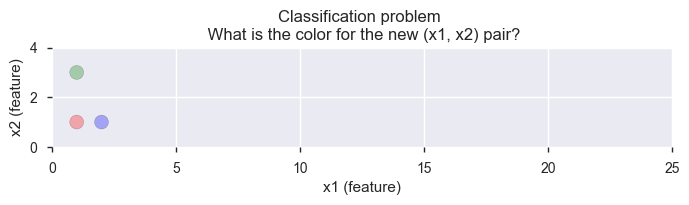

In [18]:
X = np.array([[1, 3], [2, 1], [1, 1]])
y = np.array([0, 1, 2])
plot_points_scaled(X, y)

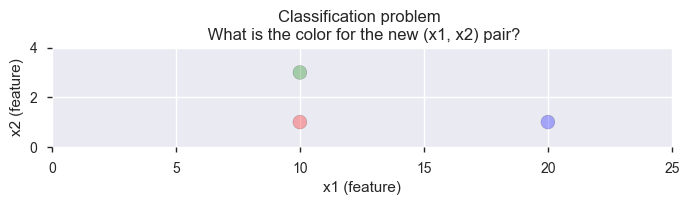

In [19]:
X = np.array([[10, 3], [20, 1], [10, 1]])
y = np.array([0, 1, 2])
plot_points_scaled(X, y)

### для градиентного спуска

<img src="pics/grad.png">

### MinMaxScaler

Привести к значениям из $[0, 1]$:
$$X = (X - X.min())/(X.max() - X.min())$$



In [20]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, Imputer

def get_num_cols(df):
    return df[['Age', 'Fare']]

pipeline = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), MinMaxScaler()),
])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
pipeline.fit_transform(df_train)

array([[0.27117366, 0.01415106],
       [0.4722292 , 0.13913574],
       [0.32143755, 0.01546857],
       ...,
       [0.36792055, 0.04577135],
       [0.32143755, 0.0585561 ],
       [0.39683338, 0.01512699]])

### StandardScaler

Привести к значениям с $mean = 0$ и $std = 1$:
$$X = (X - X.mean())/X.std()$$



In [22]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer

def get_num_cols(df):
    return df[['Age', 'Fare']]

pipeline = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), StandardScaler()),
])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [23]:
pipeline.fit_transform(df_train)

array([[-0.5924806 , -0.50244517],
       [ 0.63878901,  0.78684529],
       [-0.2846632 , -0.48885426],
       ...,
       [ 0.        , -0.17626324],
       [-0.2846632 , -0.04438104],
       [ 0.17706291, -0.49237783]])

# Комбинации признаков

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesSum(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return np.sum(X, axis=1).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [25]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer

def get_num_cols(df):
    return df[['Age', 'Fare']]

pipeline = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), FeaturesSum(), StandardScaler()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), StandardScaler()),
])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [26]:
pipeline.fit_transform(df_train)

array([[-0.62225381, -0.5924806 , -0.50244517],
       [ 0.90289025,  0.63878901,  0.78684529],
       [-0.53316528, -0.2846632 , -0.48885426],
       ...,
       [-0.16682341,  0.        , -0.17626324],
       [-0.11249595, -0.2846632 , -0.04438104],
       [-0.42216194,  0.17706291, -0.49237783]])

* сумма
* умножение
* деление

* Известны цена и площадь квартиры - посчитать стоимость квадратного метра

Предложите идеи для Titanic

# Выбросы

In [27]:
n_outliers = 3

x = 100 * np.random.rand(100, 1)
x_out = np.random.rand(n_outliers, 1) 
y = 100 + 2 * x + 10 * np.random.randn(100, 1)
y_out = 4 + 3 * x_out + 10 * np.random.randn(n_outliers, 1)
x = np.vstack([x, x_out])
y = np.vstack([y, y_out])
df = pd.DataFrame(np.hstack([x, y]), columns=['x', 'y'])
df.tail()

,x,y
98,14.33,128.75
99,40.24,177.76
100,0.90,-2.94
101,0.29,6.95
102,0.71,12.76


Text(0, 0.5, 'y (target)')

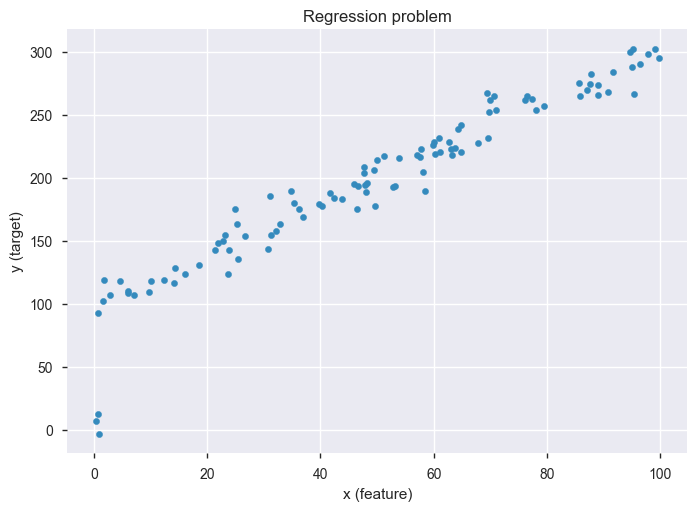

In [28]:
df.plot.scatter('x', 'y')
plt.title("Regression problem")
plt.xlabel("x (feature)")
plt.ylabel("y (target)")

In [29]:
from sklearn.linear_model import LinearRegression

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


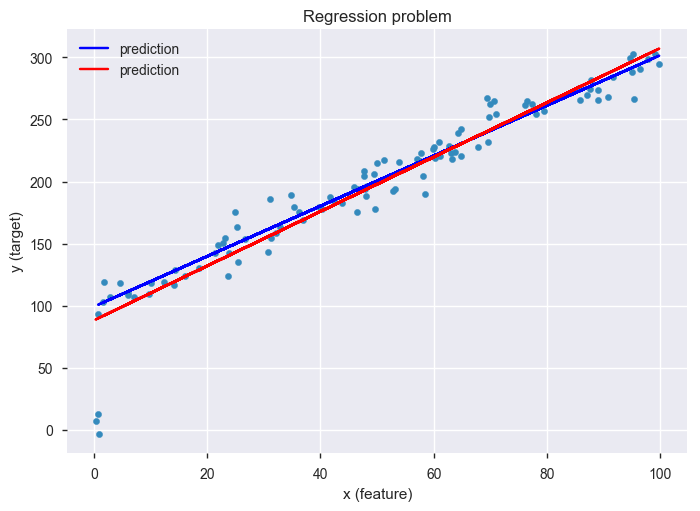

In [30]:
reg = LinearRegression()
reg.fit(x[:-n_outliers].reshape(-1, 1), y[:-n_outliers])
reg_out = LinearRegression()
reg_out.fit(x.reshape(-1, 1), y)
df.plot.scatter('x', 'y')
plt.title("Regression problem")
plt.xlabel("x (feature)")
plt.ylabel("y (target)")
plt.plot(x[:-n_outliers], reg.predict(x[:-n_outliers]), color='blue', label='prediction')
plt.plot(x, reg_out.predict(x), color='red', label='prediction')
plt.legend()

# Label encoding

In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
print(le.fit(["paris", "paris", "tokyo", "amsterdam"]))
print(le.classes_)
print(le.transform(["tokyo", "tokyo", "paris"]))
print(le.inverse_transform([2, 2, 1]))

LabelEncoder()
['amsterdam' 'paris' 'tokyo']
[2 2 1]
['tokyo' 'tokyo' 'paris']


In [32]:
# https://github.com/scikit-learn/scikit-learn/pull/9151 - 9 days ago!

class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [33]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

def get_sex_col(df):
    return df[['Sex']]

def get_num_cols(df):
    return df[['Age', 'Fare']]

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_sex_col, validate=False),  LabelEncoderPipelineFriendly()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), FeaturesSum(), StandardScaler()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), MinMaxScaler()),
])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [34]:
vec.fit_transform(df_train)

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 1.        , -0.62225381,  0.27117366,  0.01415106],
       [ 0.        ,  0.90289025,  0.4722292 ,  0.13913574],
       [ 0.        , -0.53316528,  0.32143755,  0.01546857],
       ...,
       [ 0.        , -0.16682341,  0.36792055,  0.04577135],
       [ 1.        , -0.11249595,  0.32143755,  0.0585561 ],
       [ 1.        , -0.42216194,  0.39683338,  0.01512699]])

# OneHotEncoder

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


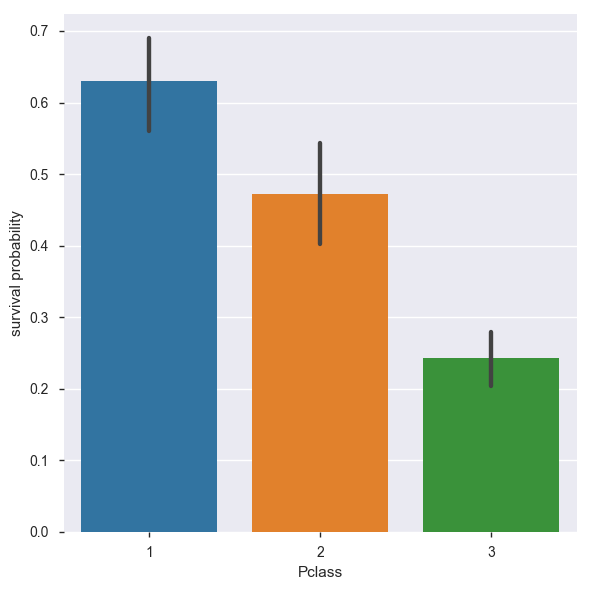

In [35]:
g = sns.factorplot(x="Pclass", y="Survived", data=df_train, size=6, kind="bar")
g.set_ylabels("survival probability")

In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
1
2
3
3
2
1

  1 2 3

1:1 0 0
2:0 1 0
3:0 0 1
4:0 0 1
5:0 1 0
6:1 0 0
    
    
1, 1, 1
2, 2, 1
3, 3, 1

IndentationError: unexpected indent (<ipython-input-37-48e589b7a6e4>, line 8)

In [38]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

def get_sex_col(df):
    return df[['Sex']]

def get_pclass_col(df):
    return df[['Pclass']]

def get_num_cols(df):
    return df[['Age', 'Fare']]

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False),  OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False),  LabelEncoderPipelineFriendly()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), FeaturesSum(), StandardScaler()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), MinMaxScaler()),
])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [39]:
vec.fit_transform(df_train)

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: 

array([[ 0.        ,  0.        ,  1.        , ..., -0.62225381,
         0.27117366,  0.01415106],
       [ 1.        ,  0.        ,  0.        , ...,  0.90289025,
         0.4722292 ,  0.13913574],
       [ 0.        ,  0.        ,  1.        , ..., -0.53316528,
         0.32143755,  0.01546857],
       ...,
       [ 0.        ,  0.        ,  1.        , ..., -0.16682341,
         0.36792055,  0.04577135],
       [ 1.        ,  0.        ,  0.        , ..., -0.11249595,
         0.32143755,  0.0585561 ],
       [ 0.        ,  0.        ,  1.        , ..., -0.42216194,
         0.39683338,  0.01512699]])

Какой способ лучше для представления Pclass?

# Другие виды признаков

## Дата и время
Добавить признаки периодичности данных:
* день недели
* день месяца
* месяц
* год
* час
* секунда
...

Признаки относительно событий:
* дней до зарплаты
* дней после зарплаты
* дней до праздников
* дней прошло с момента последней покупки
...



## Гео данные

* средняя стоимость жилья в том же квартале
* расстояние до ближайшей поликлиники
* расстояние до воды
* расстояние до центра кластера среди объектов

## Предметная область
* деньги - определить, цена округлена или присутствует \*.99
* наличие сезонности - фрукты (зима\лето)
* ваши варианты?

# Обучение модели

In [40]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

def get_sex_col(df):
    return df[['Sex']]

def get_pclass_col(df):
    return df[['Pclass']]

def get_sum_cols(df):
    return df[['Age', 'Fare']]

def get_num_cols(df):
    return df[['Age', 'Fare', 'SibSp', 'Parch']]

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False),  OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False),  LabelEncoderPipelineFriendly()),
    make_pipeline(FunctionTransformer(get_sum_cols, validate=False), Imputer(strategy='mean'), FeaturesSum(), StandardScaler()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), MinMaxScaler()),
])

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
x_train = vec.fit_transform(df_train)
x_train.shape

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: 

(891, 9)

In [42]:
y_train = df_train['Survived']
y_train.shape

(891,)

In [45]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=10)
lr.fit(x_train, y_train)
lr

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [46]:
lr.scores_

{1: array([[0.61111111, 0.61111111, 0.66666667, 0.72222222, 0.78888889,
         0.8       , 0.78888889, 0.78888889, 0.78888889, 0.78888889],
        [0.61111111, 0.61111111, 0.65555556, 0.73333333, 0.78888889,
         0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.77777778],
        [0.61797753, 0.62921348, 0.71910112, 0.75280899, 0.79775281,
         0.7752809 , 0.75280899, 0.75280899, 0.75280899, 0.75280899],
        [0.61797753, 0.61797753, 0.7752809 , 0.84269663, 0.85393258,
         0.83146067, 0.82022472, 0.82022472, 0.82022472, 0.82022472],
        [0.61797753, 0.61797753, 0.68539326, 0.79775281, 0.7752809 ,
         0.79775281, 0.80898876, 0.80898876, 0.80898876, 0.80898876],
        [0.61797753, 0.61797753, 0.6741573 , 0.80898876, 0.7752809 ,
         0.76404494, 0.76404494, 0.76404494, 0.76404494, 0.76404494],
        [0.61797753, 0.61797753, 0.71910112, 0.75280899, 0.76404494,
         0.78651685, 0.80898876, 0.79775281, 0.79775281, 0.79775281],
        [0.61797753, 0.6

In [47]:
lr.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [48]:
lr.C_

array([2.7825594])

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, lr.predict(x_train))

0.8035914702581369

# Применение модели

In [50]:
x_test = vec.fit_transform(df_test) 
x_test.shape

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: 

(418, 9)

In [51]:
y_test = lr.predict(x_test)

In [52]:
y_test.shape

(418,)

In [53]:
df_predicted = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_test})

In [54]:
df_predicted.to_csv('sample_submission.csv', sep=',', index=False)

In [57]:
from pyspark import SparkContext, SparkConf
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import UserDefinedFunction
from pyspark.mllib.linalg import Vectors

import pyspark_csv as pycsv


DATADIR = "~/sparkling-titanic/data" # data directory

def mySparkContext():
    """
    Sets the Spark Context
    """
    conf = (SparkConf()
            .setMaster("local")
            .setAppName("Titanic Logistic Regression")
            .set("spark.executor.memory", "1g"))
    sc = SparkContext(conf = conf)
    return sc

sc = mySparkContext()
sqlCtx = SQLContext(sc)
sc.addPyFile("Spark/spark-1.3.1-bin-hadoop2.4/pyspark_csv.py")

def loadDF(filename):
    """
    Load and parse filename as pyspark.sql.DataFrame
    using pyspark_csv.py
    """
    path = ""
    plain = sc.textFile(path)
    df = pycsv.csvToDataFrame(sqlCtx, plain, sep=',')
    return df

# DataFrames are immutable. Must transform RDD to another RDD for binary sex
udf = UserDefinedFunction(lambda x: 1 if x == "male" else 0, IntegerType())

def sexToBin(df):
    """
    Maps male to 1 and female to 0
    """
    df = df.select(*[udf(column).alias('Sex') \
    if column == 'Sex' else column for column in df.columns])
    return df

#------------------------------------------------------------

if __name__ == "__main__":
    
    train = loadDF("train.csv")
    test = loadDF("test.csv")

    testPassengerId = test.select('PassengerId').map(lambda x: x.PassengerId)

    train = train.select('Survived', 'Pclass', 'Sex', 'SibSp', 'Parch')
    test = test.select('Pclass', 'Sex', 'SibSp', 'Parch')

    train = sexToBin(train)
    test = sexToBin(test)

    print ("number of men in train and test resp. : %d, %d" \
        %(train.select('Sex').map(lambda x: x.Sex).sum() \
        ,test.select('Sex').map(lambda x: x.Sex).sum()))

    # format train for Logistic Regression as (label, features)
    ntrain = train.map(lambda x: Row(label=float(x[0]) \
         ,features=Vectors.dense(x[1:]))).toDF().cache() # Logistic Regression is iterative, need caching
    ntest = test.map(lambda x: Row(features=Vectors.dense(x[0:]))).toDF()
    
    lr = LogisticRegression(maxIter=100, regParam=0.1)
    model = lr.fit(ntrain)
    pred = model.transform(ntest).select('prediction').map(lambda x: x.prediction)
    a
    # configure the submission format as follows
    submit = sqlCtx.createDataFrame(testPassengerId.zip(pred), ["PassengerId", "Survived"])
    """
    NOTE: rdd1.zip(rdd2) works provided that both RDDs have the same partitioner and the same number 
    of elements per partition, otherwise should either repartition or can do:
    submit = sqlCtx.createDataFrame(pred.zipWithIndex().map(lambda x: (x[1]+892L, x[0])), ["PassengerId", "Survived"])
    where 891L is the number training samples
    """
    os.chdir(DATADIR)
    # file is small so can save pandas.DataFrame as csv
    submit.toPandas().to_csv("prediction.csv", index=False)
    # if not, should saveAsTextFile:
    # submit.rdd.saveAsTextFile("../Titanic/data/prediction")
    sc.stop()

ModuleNotFoundError: No module named 'pyspark'